In [55]:
%load_ext autoreload 
%autoreload 2 

import torch
from torch.utils.data import DataLoader
from train import Trainer
from generator import *
from discriminator import GAN
from dataset import CocoStuffDataSet

import numpy as np
from numpy import linalg as LA
# Sciki-learn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
# Visualisation
import matplotlib.pyplot as plt

from utils import *
NUM_CLASSES = 11
SAVE_DIR = "../checkpoints" # Assuming this is launched from code/ subfolder.
# experiment_name = 'gan_animal'
# experiment_name = 'animal-batchnorm-50-nobnend'
experiment_name = 'animal-bn-50-gan-55'
use_bn = True
experiment_dir = os.path.join(SAVE_DIR, experiment_name)
batch_size = 64

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
HEIGHT, WIDTH = 128, 128
val_loader = DataLoader(CocoStuffDataSet(mode='val', supercategories=['animal'], height=HEIGHT, width=WIDTH),
                            batch_size, shuffle=False)
train_loader = DataLoader(CocoStuffDataSet(mode='train', supercategories=['animal'], height=HEIGHT, width=WIDTH),
                            batch_size, shuffle=False)

In [56]:
generator = SegNet16(NUM_CLASSES, use_bn=use_bn)
image_shape = (3, HEIGHT, WIDTH)
segmentation_shape = (NUM_CLASSES, HEIGHT, WIDTH)
# discriminator = GAN(NUM_CLASSES, segmentation_shape, image_shape)
discriminator = None
trainer = Trainer(generator, discriminator, train_loader, val_loader, \
                experiment_dir=experiment_dir, resume=True, load_iter=None)


Using BatchNorm in decoder
44
Using device cuda:0
Runing network without GAN loss.
=> loading checkpoint '../checkpoints/animal-bn-50-gan-55/best.pth.tar'
=> loaded checkpoint '../checkpoints/animal-bn-50-gan-55/best.pth.tar' (iter 151)


In [57]:
def retrieve_features(trainer, loader, number):
    '''
    Retrieves features for at least number images from the loader 
    Returns 
    features ND-array B x feature_size
    dominant_classes ND-array size B containing index of dominant class in image
    '''
    total = 0
    to_return = None
    dominant_classes = []
    for data, mask_gt, gt_visual in loader:
        if number is None or total < number:      
            data = data.to(trainer.device)
            batch_size = data.size()[0]
            total += batch_size
            features = trainer._gen.get_feature_embedding(data).detach().cpu().numpy() # B x 512 x 4 x 4
            features = np.reshape(features, (batch_size, -1))
            classes = dominant_class(gt_visual, loader.dataset.numClasses)
            if to_return is None:
                to_return = features
                dominant_classes = classes
            else: 
                to_return = np.concatenate([to_return, features], axis=0)
                dominant_classes = np.concatenate([dominant_classes, classes], axis=0)
        else:
            break
    return to_return, dominant_classes

In [58]:
features, classes = retrieve_features(trainer, val_loader, None)
print ("Retrieved features")
# Standardize features
scaler = StandardScaler()
scaler.fit(features)
std_features = scaler.transform(features)

# Apply PCA to each of the features

intermediate_value = 200
pca = PCA(n_components=intermediate_value)
pca.fit(std_features)
transformed_features = pca.transform(std_features)

print ("Applied PCA")
# Apply t-SNE to the transformed features for visualisation
embedded_features = TSNE(n_components=2).fit_transform(transformed_features)


Retrieved features
Applied PCA


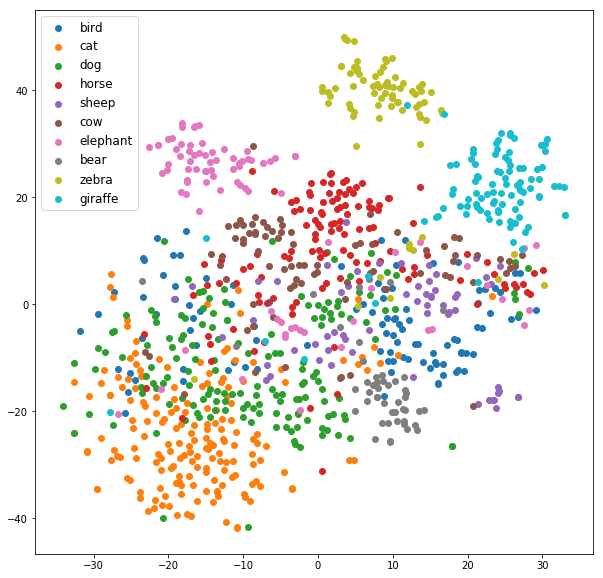

In [59]:
# Visualise data
fig = plt.figure(1, figsize=(10, 10))
plt.clf()
L = len(set(classes))

# Generate L random colors
colors = [(
        np.random.randint(0,255)/255, 
        np.random.randint(0,255)/255, 
        np.random.randint(0,255)/255) for i in range(L)]

dataset = val_loader.dataset
coco = dataset.coco
all_cats_ids = coco.getCatIds()
cats = coco.loadCats(all_cats_ids)
nms=[cat['name'] for cat in cats]
animal_cat_names = [nms[all_cats_ids.index(i)] for i in val_loader.dataset.catIds]

for i in range(val_loader.dataset.numClasses - 1):
    batch = embedded_features[classes==i]
    plt.scatter(batch[:,0], batch[:,1], label=animal_cat_names[i])
plt.legend(loc='upper left', numpoints=1, ncol=1, fontsize=12)
plt.show()